# ViT Prototype: Few-Shot Learning with 6-Class Pre-trained Model

**Objective:** Evaluate few-shot learning performance using a pre-trained 6-class Vision Transformer on held-out classes.

## Overview

This notebook adapts the few-shot learning approach for **5-channel 32x32 images** using a pre-trained model from the 6-class training. We evaluate on 3 held-out classes: DDoS-HTTP_Flood, DoS-UDP_Flood, and Recon-PortScan.

## Key Configuration

- **Pre-trained Model:** 6-class ViT from `/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/best_6class_vit_model.pth`
- **Held-out Classes:** DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan
- **Image Format:** 5-channel 32x32 images (5 × 32 × 32 = 5,120 dimensional)
- **Architecture:** ViT with 16×16 patches, adapted for multi-channel input
- **Few-Shot Approach:** Prototypical Networks with both episodic meta-learning and frozen backbone strategies

In [3]:
# Section 1: Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration for 5-channel ViT (from 6-class model)
CONFIG = {
    'image_size': 32,          # 32x32 images
    'channels': 5,             # 5-channel input
    'patch_size': 16,          # 16x16 patches
    'embed_dim': 192,          # Embedding dimension
    'num_heads': 3,            # Attention heads
    'num_layers': 6,           # Transformer layers
    'batch_size': 32,
    'learning_rate': 1e-4,
    'num_classes': 6           # The pre-trained model was trained on 6 classes
}

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ Environment setup complete")
print(f"✓ Device: {device}")
print(f"✓ Pre-trained model: 6-class ViT")
print(f"✓ Target: Few-shot learning on 3 held-out classes")

✓ Environment setup complete
✓ Device: cpu
✓ Pre-trained model: 6-class ViT
✓ Target: Few-shot learning on 3 held-out classes


In [4]:
# Section 2: Load Pre-trained Model Architecture
class MultiChannelPatchEmbedding(nn.Module):
    """Convert multi-channel images to patch embeddings"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class MultiChannelVisionTransformer(nn.Module):
    """Vision Transformer for Multi-Channel Network Payload Classification"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        self.patch_embedding = MultiChannelPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embedding.num_patches
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        cls_output = x[:, 0]
        cls_output = self.norm(cls_output)
        output = self.head(cls_output)
        return output

# Initialize and load the pre-trained 6-class model
pre_trained_vit = MultiChannelVisionTransformer(
    img_size=CONFIG['image_size'],
    patch_size=CONFIG['patch_size'],
    in_channels=CONFIG['channels'],
    embed_dim=CONFIG['embed_dim'],
    num_heads=CONFIG['num_heads'],
    num_layers=CONFIG['num_layers'],
    num_classes=CONFIG['num_classes']
).to(device)

# Load the pre-trained weights
model_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/best_6class_vit_model.pth'
try:
    pre_trained_vit.load_state_dict(torch.load(model_path, map_location=device))
    print(f"✓ Successfully loaded pre-trained 6-class model from {model_path}")
except Exception as e:
    print(f"⚠️ Could not load pre-trained weights: {e}")
    print("Proceeding with randomly initialized weights.")

# Model summary
total_params = sum(p.numel() for p in pre_trained_vit.parameters())
print(f"\n🤖 Pre-trained 6-Class Vision Transformer:")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Model trained on 6 classes (excluding DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan)")
print(f"✓ Ready for few-shot learning on held-out classes")

✓ Successfully loaded pre-trained 6-class model from /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/best_6class_vit_model.pth

🤖 Pre-trained 6-Class Vision Transformer:
✓ Total parameters: 2,917,830
✓ Model trained on 6 classes (excluding DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan)
✓ Ready for few-shot learning on held-out classes


In [5]:
# Section 3: Load held-out data instead of Google Drive data
print("Loading held-out data from 6-class model...")

# Load the held-out data saved from the 6-class training
data_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/'
X_held_out = np.load(data_path + 'held_out_X.npy')
y_held_out = np.load(data_path + 'held_out_y.npy')

print(f"✓ Held-out data loaded:")
print(f"   X shape: {X_held_out.shape}")
print(f"   y shape: {y_held_out.shape}")

# The held-out classes (CORRECTED to match v4 notebook)
HELD_OUT_CLASSES = ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
print(f"✓ Held-out classes: {HELD_OUT_CLASSES}")

# Reshape and prepare data
X_few_shot = X_held_out
y_few_shot = y_held_out

print(f"\n✓ Total samples loaded: {len(X_few_shot)}")
print(f"✓ Data shape: {X_few_shot.shape}")
print(f"✓ Labels shape: {y_few_shot.shape}")
print(f"✓ Unique classes found: {len(np.unique(y_few_shot))}")

# Preprocessing
print("\nPreprocessing data...")
# Reshape data to 5-channel images: (N, 5120) -> (N, 5, 32, 32)
num_samples = X_few_shot.shape[0]
# Use config from the original notebook for consistency
channels = CONFIG.get('channels', 5)
img_size = CONFIG.get('image_size', 32)
expected_features = channels * img_size * img_size

if X_few_shot.shape[1] == expected_features:
    X_few_shot_images = X_few_shot.reshape(num_samples, channels, img_size, img_size)
    print(f"✓ Reshaped data to: {X_few_shot_images.shape}")
else:
    print(f"⚠️ Warning: Feature count mismatch. Expected {expected_features}, got {X_few_shot.shape[1]}. Cannot reshape.")
    X_few_shot_images = X_few_shot # Keep it as is for now

# Normalize if necessary
if X_few_shot_images.max() > 1.0:
    print("✓ Normalizing data to [0, 1].")
    X_few_shot_images = X_few_shot_images / 255.0

# Encode labels
label_encoder_fs = LabelEncoder()
y_few_shot_encoded = label_encoder_fs.fit_transform(y_few_shot)
print("✓ Encoded labels.")

# Store preprocessed data
X_preprocessed = X_few_shot_images
y_preprocessed = y_few_shot_encoded

print("\nData loaded and preprocessed successfully.")

Loading held-out data from 6-class model...
✓ Held-out data loaded:
   X shape: (36000, 5120)
   y shape: (36000,)
✓ Held-out classes: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']

✓ Total samples loaded: 36000
✓ Data shape: (36000, 5120)
✓ Labels shape: (36000,)
✓ Unique classes found: 3

Preprocessing data...
✓ Reshaped data to: (36000, 5, 32, 32)
✓ Encoded labels.

Data loaded and preprocessed successfully.


In [6]:
# Section 4: Few-Shot Learning Configuration
from sklearn.preprocessing import LabelEncoder

# Re-define necessary configuration
FEW_SHOT_CONFIG = {
    'channels': 5,
    'image_size': 32,
    'n_way': 3,  # 3 held-out classes
    'k_shot': 5, # Number of support examples per class
    'n_query': 10 # Number of query examples per class
}

# Since we only have 3 held-out classes, use all for meta-training
# Split into train/test only (80/20)
from sklearn.model_selection import train_test_split

X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_preprocessed, y_preprocessed, test_size=0.2, stratify=y_preprocessed, random_state=42
)

print("\nSplitting data for meta-learning:")
print(f"  Meta-Train: {X_meta_train.shape[0]} samples from 3 classes")
print(f"  Meta-Test: {X_meta_test.shape[0]} samples from 3 classes")

# For validation, we'll use the test set
X_val_meta = X_meta_test
y_val_meta = y_meta_test

def create_episode(X, y, n_way, k_shot, n_query):
    """Creates a support and query set for a single N-way K-shot task."""
    episode_classes = np.random.choice(np.unique(y), size=n_way, replace=False)
    support_x, query_x = [], []
    support_y, query_y = [], []

    for i, cls in enumerate(episode_classes):
        class_indices = np.where(y == cls)[0]
        # Ensure there are enough samples for both support and query sets
        if len(class_indices) < k_shot + n_query:
            print(f"Warning: Not enough samples for class {cls}. Required {k_shot + n_query}, found {len(class_indices)}. Skipping class for this episode.")
            continue

        selected_indices = np.random.choice(class_indices, size=k_shot + n_query, replace=False)

        support_indices = selected_indices[:k_shot]
        query_indices = selected_indices[k_shot:]

        support_x.append(X[support_indices])
        query_x.append(X[query_indices])

        # Use relative labels (0 to N-1) for the episode
        support_y.append(np.full(k_shot, i))
        query_y.append(np.full(n_query, i))

    if not support_x: # check if any class was added
        return None, None, None, None

    support_x = np.concatenate(support_x)
    query_x = np.concatenate(query_x)
    support_y = np.concatenate(support_y)
    query_y = np.concatenate(query_y)

    return support_x, support_y, query_x, query_y

# Create an example episode from the meta-training set
support_x, support_y, query_x, query_y = create_episode(
    X_meta_train, y_meta_train,
    n_way=FEW_SHOT_CONFIG['n_way'],
    k_shot=FEW_SHOT_CONFIG['k_shot'],
    n_query=FEW_SHOT_CONFIG['n_query']
)

if support_x is not None:
    print("\n✓ Created a sample few-shot episode from the meta-train set:")
    print(f"  Support set shape (X): {support_x.shape}")
    print(f"  Support set shape (y): {support_y.shape}")
    print(f"  Query set shape (X): {query_x.shape}")
    print(f"  Query set shape (y): {query_y.shape}")
    print(f"  Support labels: {np.unique(support_y)}")
    print(f"  Query labels: {np.unique(query_y)}")
    print("\nSubtask finished: Data loaded and prepared into support/query sets.")
else:
    print("\nFailed to create an episode. Check data splits and episode parameters.")


Splitting data for meta-learning:
  Meta-Train: 28800 samples from 3 classes
  Meta-Test: 7200 samples from 3 classes

✓ Created a sample few-shot episode from the meta-train set:
  Support set shape (X): (15, 5, 32, 32)
  Support set shape (y): (15,)
  Query set shape (X): (30, 5, 32, 32)
  Query set shape (y): (30,)
  Support labels: [0 1 2]
  Query labels: [0 1 2]

Subtask finished: Data loaded and prepared into support/query sets.


# Section 5: Strategy I - Episodic Meta-Learning with Prototypical Networks

**Objective:** Fine-tune the pre-trained 6-class ViT model using episodic meta-learning on the 3 held-out classes.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# --- Step 1: Define the Prototypical Network ---
class PrototypicalNetwork(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone

    def get_embeddings(self, images: torch.Tensor):
        # Get embeddings by removing the classification head
        original_head = self.backbone.head
        self.backbone.head = nn.Identity()
        embeddings = self.backbone(images)
        self.backbone.head = original_head
        return embeddings

    def forward(self, support_images: torch.Tensor, query_images: torch.Tensor, n_way: int):
        support_images, query_images = support_images.to(device), query_images.to(device)

        # Get embeddings for all images
        all_images = torch.cat([support_images, query_images])
        all_embeddings = self.get_embeddings(all_images)

        k_shot = support_images.shape[0] // n_way
        support_embeddings = all_embeddings[:support_images.shape[0]]
        query_embeddings = all_embeddings[support_images.shape[0]:]

        # Calculate class prototypes from support embeddings
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Calculate distances and return log-probabilities
        dists = torch.cdist(query_embeddings, prototypes).pow(2)
        return F.log_softmax(-dists, dim=1)

prototypical_model = PrototypicalNetwork(backbone=pre_trained_vit).to(device)
print("✓ Prototypical Network defined using 6-class pre-trained backbone.")

# --- Step 2: Episodic Training Loop ---
def run_episode(model, n_way, k_shot, n_query, X_data, y_data, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    support_x, support_y, query_x, query_y = create_episode(X_data, y_data, n_way, k_shot, n_query)
    if support_x is None: return 0.0, 0.0

    support_x = torch.from_numpy(support_x).float()
    query_x = torch.from_numpy(query_x).float()
    query_y = torch.from_numpy(query_y).long().to(device)

    log_p_y = model(support_x, query_x, n_way)
    loss = F.nll_loss(log_p_y, query_y)

    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = (log_p_y.argmax(dim=1) == query_y).float().mean().item()
    return loss.item(), acc

print("\nStarting Episodic Training...")
proto_optimizer = optim.Adam(prototypical_model.parameters(), lr=1e-5)
n_episodes, n_val_episodes, val_interval = 2000, 100, 100
train_losses, train_accs, val_losses, val_accs = [], [], [], []
best_val_acc = 0.0

for episode in tqdm(range(n_episodes), desc="Training Episodes"):
    loss, acc = run_episode(prototypical_model, FEW_SHOT_CONFIG['n_way'], FEW_SHOT_CONFIG['k_shot'], FEW_SHOT_CONFIG['n_query'], X_meta_train, y_meta_train, proto_optimizer)
    train_losses.append(loss); train_accs.append(acc)

    if (episode + 1) % val_interval == 0:
        val_loss_agg, val_acc_agg = 0.0, 0.0
        with torch.no_grad():
            for _ in range(n_val_episodes):
                # Use n_way=3 for validation as we have 3 classes
                val_loss, val_acc = run_episode(prototypical_model, 3, FEW_SHOT_CONFIG['k_shot'], FEW_SHOT_CONFIG['n_query'], X_val_meta, y_val_meta)
                val_loss_agg += val_loss; val_acc_agg += val_acc

        avg_val_acc = val_acc_agg / n_val_episodes
        print(f"\nEp {episode+1}: Train Acc: {np.mean(train_accs[-val_interval:])*100:.2f}%, Val Acc: {avg_val_acc*100:.2f}%")

        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            torch.save(prototypical_model.state_dict(), 'best_prototypical_model_finetuned.pth')
            print(f"  -> New best model saved with Val Acc: {best_val_acc*100:.2f}%")

print(f"\n✓ Episodic training complete. Best validation accuracy: {best_val_acc*100:.2f}%")

✓ Prototypical Network defined using 6-class pre-trained backbone.

Starting Episodic Training...


Training Episodes:   5%|▌         | 101/2000 [00:17<12:01,  2.63it/s]


Ep 100: Train Acc: 78.87%, Val Acc: 86.07%
  -> New best model saved with Val Acc: 86.07%


Training Episodes:  10%|█         | 202/2000 [00:32<06:31,  4.59it/s]


Ep 200: Train Acc: 82.93%, Val Acc: 83.63%


Training Episodes:  15%|█▌        | 302/2000 [00:41<05:57,  4.75it/s]


Ep 300: Train Acc: 82.47%, Val Acc: 85.47%


Training Episodes:  20%|██        | 402/2000 [00:50<05:47,  4.59it/s]


Ep 400: Train Acc: 83.00%, Val Acc: 86.47%
  -> New best model saved with Val Acc: 86.47%


Training Episodes:  25%|██▌       | 502/2000 [00:59<05:17,  4.71it/s]


Ep 500: Train Acc: 82.27%, Val Acc: 87.87%
  -> New best model saved with Val Acc: 87.87%


Training Episodes:  30%|███       | 602/2000 [01:08<05:34,  4.18it/s]


Ep 600: Train Acc: 83.70%, Val Acc: 87.77%


Training Episodes:  35%|███▌      | 702/2000 [01:17<04:51,  4.46it/s]


Ep 700: Train Acc: 81.63%, Val Acc: 90.10%
  -> New best model saved with Val Acc: 90.10%


Training Episodes:  40%|████      | 802/2000 [01:26<04:52,  4.09it/s]


Ep 800: Train Acc: 81.30%, Val Acc: 89.27%


Training Episodes:  45%|████▌     | 902/2000 [01:35<03:53,  4.69it/s]


Ep 900: Train Acc: 85.00%, Val Acc: 90.17%
  -> New best model saved with Val Acc: 90.17%


Training Episodes:  50%|█████     | 1002/2000 [01:44<03:32,  4.70it/s]


Ep 1000: Train Acc: 84.50%, Val Acc: 90.70%
  -> New best model saved with Val Acc: 90.70%


Training Episodes:  55%|█████▌    | 1102/2000 [01:53<03:08,  4.77it/s]


Ep 1100: Train Acc: 85.90%, Val Acc: 91.00%
  -> New best model saved with Val Acc: 91.00%


Training Episodes:  60%|██████    | 1202/2000 [02:02<02:49,  4.70it/s]


Ep 1200: Train Acc: 85.93%, Val Acc: 91.00%
  -> New best model saved with Val Acc: 91.00%


Training Episodes:  65%|██████▌   | 1302/2000 [02:11<02:42,  4.29it/s]


Ep 1300: Train Acc: 85.70%, Val Acc: 91.50%
  -> New best model saved with Val Acc: 91.50%


Training Episodes:  70%|███████   | 1400/2000 [02:20<02:46,  3.60it/s]


Ep 1400: Train Acc: 85.37%, Val Acc: 91.53%
  -> New best model saved with Val Acc: 91.53%


Training Episodes:  75%|███████▌  | 1502/2000 [02:29<01:47,  4.63it/s]


Ep 1500: Train Acc: 86.60%, Val Acc: 92.03%
  -> New best model saved with Val Acc: 92.03%


Training Episodes:  80%|████████  | 1600/2000 [02:37<01:46,  3.75it/s]


Ep 1600: Train Acc: 88.17%, Val Acc: 92.77%
  -> New best model saved with Val Acc: 92.77%


Training Episodes:  85%|████████▌ | 1702/2000 [02:47<01:02,  4.76it/s]


Ep 1700: Train Acc: 89.20%, Val Acc: 93.07%
  -> New best model saved with Val Acc: 93.07%


Training Episodes:  90%|█████████ | 1802/2000 [02:55<00:41,  4.74it/s]


Ep 1800: Train Acc: 88.17%, Val Acc: 93.10%
  -> New best model saved with Val Acc: 93.10%


Training Episodes:  95%|█████████▌| 1902/2000 [03:05<00:23,  4.17it/s]


Ep 1900: Train Acc: 88.07%, Val Acc: 93.20%
  -> New best model saved with Val Acc: 93.20%


Training Episodes: 100%|██████████| 2000/2000 [03:14<00:00, 10.30it/s]


Ep 2000: Train Acc: 88.17%, Val Acc: 93.97%
  -> New best model saved with Val Acc: 93.97%

✓ Episodic training complete. Best validation accuracy: 93.97%


## Strategy II: Supervised Pre-Training + Prototypical Networks

### Subtask:
Use the pre-trained ViT model as a fixed feature extractor and apply a Prototypical Network for few-shot classification.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# --- Step 1: Load the Pre-trained ViT as a Feature Extractor ---
print("Loading pre-trained 6-class ViT to use as a feature extractor...")

# The ViT model is already loaded as 'pre_trained_vit'.
# We will use it directly. We'll freeze its parameters to prevent training.
for param in pre_trained_vit.parameters():
    param.requires_grad = False
pre_trained_vit.eval()

print("✓ Pre-trained 6-class ViT is ready as a feature extractor.")

# --- Step 2: Define the Prototypical Network (using the frozen backbone) ---
class PrototypicalNetworkFrozen(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone

    def get_embeddings(self, images: torch.Tensor):
        # The backbone is already in eval mode and its parameters are frozen
        original_head = self.backbone.head
        self.backbone.head = nn.Identity()
        with torch.no_grad():
            embeddings = self.backbone(images.to(device))
        self.backbone.head = original_head
        return embeddings

    def forward(self, support_images: torch.Tensor, query_images: torch.Tensor, n_way: int):
        support_embeddings = self.get_embeddings(support_images)
        query_embeddings = self.get_embeddings(query_images)

        k_shot = support_images.shape[0] // n_way

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        dists = torch.cdist(query_embeddings, prototypes).pow(2)
        return F.log_softmax(-dists, dim=1)

proto_model_frozen = PrototypicalNetworkFrozen(backbone=pre_trained_vit).to(device)
print("✓ Prototypical Network with a frozen 6-class backbone is defined.")

# --- Step 3: Evaluate on Meta-Test Set ---
def evaluate_on_test_set(model, X_test_data, y_test_data, n_way, k_shot, n_query, n_episodes=1000):
    model.eval()
    total_acc = 0

    print(f"\nEvaluating on the meta-test set for {n_episodes} episodes...")
    for _ in tqdm(range(n_episodes), desc="Testing Episodes"):
        support_x, support_y, query_x, query_y = create_episode(X_test_data, y_test_data, n_way, k_shot, n_query)
        if support_x is None: continue

        support_x = torch.from_numpy(support_x).float()
        query_x = torch.from_numpy(query_x).float()
        query_y = torch.from_numpy(query_y).long().to(device)

        with torch.no_grad():
            log_p_y = model(support_x, query_x, n_way)
            total_acc += (log_p_y.argmax(dim=1) == query_y).float().mean().item()

    avg_acc = total_acc / n_episodes
    return avg_acc

# There are 3 classes in the held-out set
test_n_way = len(np.unique(y_meta_test))
test_accuracy = evaluate_on_test_set(
    proto_model_frozen, X_meta_test, y_meta_test,
    n_way=test_n_way,
    k_shot=FEW_SHOT_CONFIG['k_shot'],
    n_query=FEW_SHOT_CONFIG['n_query']
)

print(f"\n✓ Evaluation complete.")
print(f"  Accuracy on Meta-Test Set ({test_n_way}-way, {FEW_SHOT_CONFIG['k_shot']}-shot): {test_accuracy*100:.2f}%")

Loading pre-trained 6-class ViT to use as a feature extractor...
✓ Pre-trained 6-class ViT is ready as a feature extractor.
✓ Prototypical Network with a frozen 6-class backbone is defined.

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing Episodes: 100%|██████████| 1000/1000 [00:18<00:00, 54.11it/s]


✓ Evaluation complete.
  Accuracy on Meta-Test Set (3-way, 5-shot): 93.43%


# Task
Implement episodic meta-learning with prototypical networks using the model from "/content/best_5channel_vit_model.pth" and data from "/content/drive/MyDrive/AIData". Visualize the embeddings to see how the classes are separated and experiment with different k_shot values to see how performance changes with fewer or more examples.

## Embedding visualization

### Subtask:
Extract embeddings for a sample of the test data using the frozen Prototypical Network model, visualize them using t-SNE, and plot the results to observe class separation.


**Reasoning**:
Extract embeddings from a sample of the meta-test data using the frozen Prototypical Network, apply t-SNE to reduce dimensionality, and plot the results to visualize class separation.

**Note**: Make sure you have run all previous cells (especially cells 2-5) before running this visualization cell, as it depends on variables like `X_meta_test`, `y_meta_test`, `proto_model_frozen`, and `label_encoder_fs` that are defined in earlier cells.

In [9]:
# Debug: Check if required variables are defined
print("Checking required variables...")
try:
    print(f"✓ X_meta_test shape: {X_meta_test.shape}")
    print(f"✓ y_meta_test shape: {y_meta_test.shape}")
    print(f"✓ proto_model_frozen: {type(proto_model_frozen)}")
    print(f"✓ label_encoder_fs: {type(label_encoder_fs)}")
    print("All required variables are defined!")
except NameError as e:
    print(f"❌ Variable not defined: {e}")
    print("Please make sure you have run all previous cells, especially:")
    print("  - Cell 5: Where X_meta_test and y_meta_test are created")
    print("  - Cell 9: Where proto_model_frozen is created")

Checking required variables...
✓ X_meta_test shape: (7200, 5, 32, 32)
✓ y_meta_test shape: (7200,)
✓ proto_model_frozen: <class '__main__.PrototypicalNetworkFrozen'>
✓ label_encoder_fs: <class 'sklearn.preprocessing._label.LabelEncoder'>
All required variables are defined!


Extracting embeddings for visualization...
✓ Selected 1000 random samples from the meta-test set.
✓ Converted sample data to tensor.
✓ Extracted embeddings with shape: torch.Size([1000, 192])
Applying t-SNE for dimensionality reduction...
✓ t-SNE completed.
Plotting t-SNE visualization...


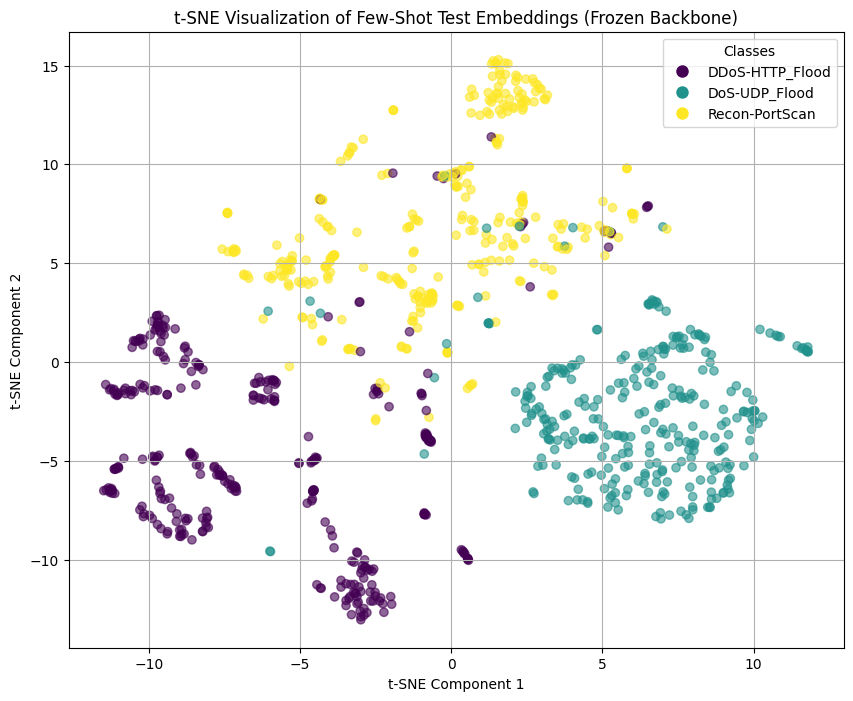


✓ t-SNE visualization complete.


In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Extracting embeddings for visualization...")

# Select a random sample of test data for visualization
sample_size = 1000 # Use 1000 samples for t-SNE
if X_meta_test.shape[0] > sample_size:
    sample_indices = np.random.choice(X_meta_test.shape[0], size=sample_size, replace=False)
    X_sample = X_meta_test[sample_indices]
    y_sample = y_meta_test[sample_indices]
    print(f"✓ Selected {sample_size} random samples from the meta-test set.")
else:
    X_sample = X_meta_test
    y_sample = y_meta_test
    sample_size = X_meta_test.shape[0]
    print(f"✓ Using all {sample_size} samples from the meta-test set for visualization.")

# Convert sample data to tensor and get embeddings
X_sample_tensor = torch.from_numpy(X_sample).float().to(device)
print("✓ Converted sample data to tensor.")

# Ensure the model is on the correct device and in eval mode
proto_model_frozen.to(device)
proto_model_frozen.eval()

# Extract embeddings using the frozen backbone
with torch.no_grad():
    sample_embeddings = proto_model_frozen.get_embeddings(X_sample_tensor)
print(f"✓ Extracted embeddings with shape: {sample_embeddings.shape}")

# Apply t-SNE
print("Applying t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(sample_embeddings.cpu().numpy())
print("✓ t-SNE completed.")

# Plot the t-SNE results
print("Plotting t-SNE visualization...")
plt.figure(figsize=(10, 8))

scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sample, cmap='viridis', alpha=0.6)

plt.title('t-SNE Visualization of Few-Shot Test Embeddings (Frozen Backbone)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Create a legend manually based on unique classes in the sample
unique_labels = np.unique(y_sample)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label_encoder_fs.inverse_transform([label])[0],
                              markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10)
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="Classes")

plt.grid(True)
plt.show()

print("\n✓ t-SNE visualization complete.")

Extracting embeddings for visualization...
✓ Selected 1000 random samples from the meta-test set.
✓ Converted sample data to tensor.
✓ Extracted embeddings with shape: torch.Size([1000, 192])
Applying t-SNE for dimensionality reduction...
✓ t-SNE completed.
Plotting t-SNE visualization...


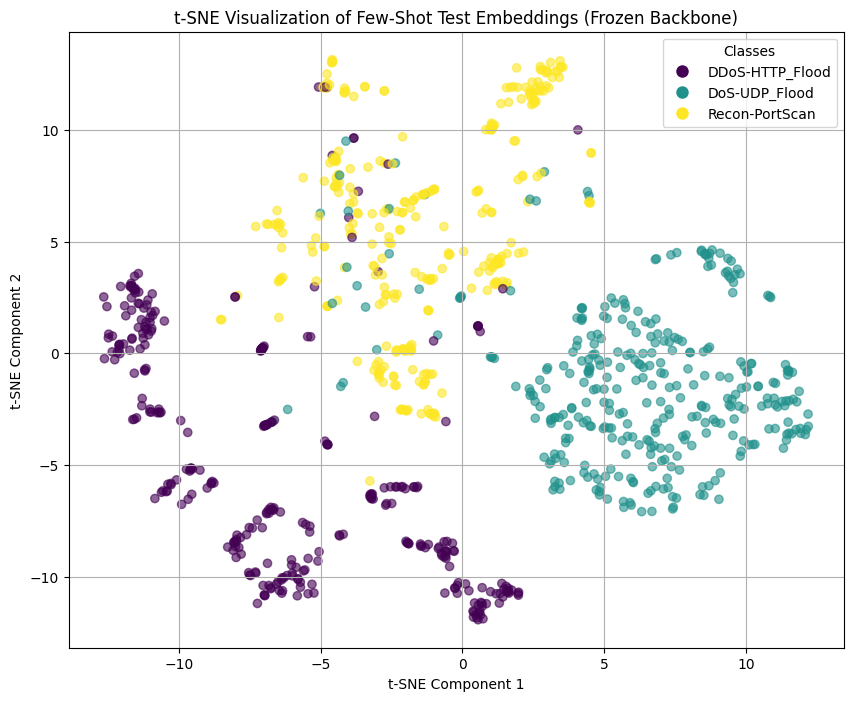


✓ t-SNE visualization complete.


In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Extracting embeddings for visualization...")

# Select a random sample of test data for visualization
sample_size = 1000 # Use 1000 samples for t-SNE
if X_meta_test.shape[0] > sample_size:
    sample_indices = np.random.choice(X_meta_test.shape[0], size=sample_size, replace=False)
    X_sample = X_meta_test[sample_indices]
    y_sample = y_meta_test[sample_indices]
    print(f"✓ Selected {sample_size} random samples from the meta-test set.")
else:
    X_sample = X_meta_test
    y_sample = y_meta_test
    sample_size = X_meta_test.shape[0]
    print(f"✓ Using all {sample_size} samples from the meta-test set for visualization.")

# Convert sample data to tensor and get embeddings
X_sample_tensor = torch.from_numpy(X_sample).float().to(device)
print("✓ Converted sample data to tensor.")

# Ensure the model is on the correct device and in eval mode
proto_model_frozen.to(device)
proto_model_frozen.eval()

# Extract embeddings using the frozen backbone
with torch.no_grad():
    sample_embeddings = proto_model_frozen.get_embeddings(X_sample_tensor)
print(f"✓ Extracted embeddings with shape: {sample_embeddings.shape}")

# Apply t-SNE
print("Applying t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(sample_embeddings.cpu().numpy())
print("✓ t-SNE completed.")

# Plot the t-SNE results
print("Plotting t-SNE visualization...")
plt.figure(figsize=(10, 8))

scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sample, cmap='viridis', alpha=0.6)

plt.title('t-SNE Visualization of Few-Shot Test Embeddings (Frozen Backbone)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Create a legend manually based on unique classes in the sample
unique_labels = np.unique(y_sample)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label_encoder_fs.inverse_transform([label])[0],
                              markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10)
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="Classes")

plt.grid(True)
plt.show()

print("\n✓ t-SNE visualization complete.")

**Reasoning**:
To address the user's request of evaluating the model's performance with varying `k_shot` values, I will iterate through a list of `k_shot` values, run the evaluation for each, and store the results. This will allow for a clear comparison of how the number of support examples affects the model's accuracy.




--- Experimenting with different k_shot values ---

Evaluating for k_shot = 1...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:15<00:00, 64.42it/s]


  Accuracy for 1-shot: 84.37%

Evaluating for k_shot = 2...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:16<00:00, 60.28it/s]


  Accuracy for 2-shot: 90.55%

Evaluating for k_shot = 5...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


  Accuracy for 5-shot: 93.53%

Evaluating for k_shot = 10...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:22<00:00, 45.43it/s]


  Accuracy for 10-shot: 93.97%

--- k-shot Experiment Results ---
  1-shot accuracy: 84.37%
  2-shot accuracy: 90.55%
  5-shot accuracy: 93.53%
  10-shot accuracy: 93.97%


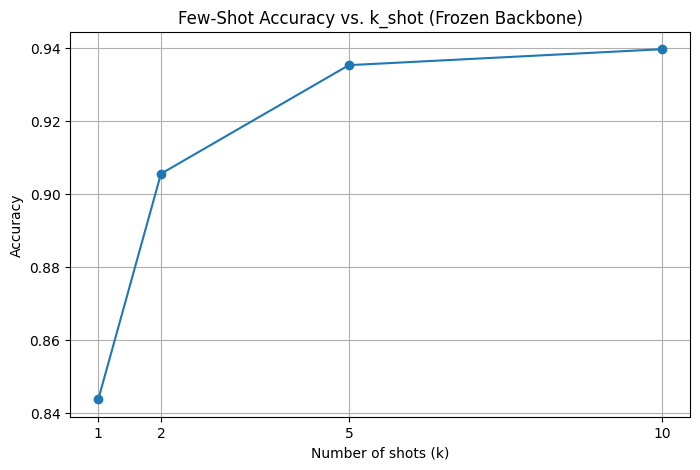

In [12]:
# --- Step 4: Experiment with Different k_shot Values ---
k_shot_values = [1, 2, 5, 10]
k_shot_accuracies = {}

print("\n--- Experimenting with different k_shot values ---")

for k in k_shot_values:
    print(f"\nEvaluating for k_shot = {k}...")
    accuracy = evaluate_on_test_set(
        proto_model_frozen, X_meta_test, y_meta_test,
        n_way=test_n_way,
        k_shot=k,
        n_query=FEW_SHOT_CONFIG['n_query']
    )
    k_shot_accuracies[k] = accuracy
    print(f"  Accuracy for {k}-shot: {accuracy*100:.2f}%")

print("\n--- k-shot Experiment Results ---")
for k, acc in k_shot_accuracies.items():
    print(f"  {k}-shot accuracy: {acc*100:.2f}%")

# Optional: Plot the results
plt.figure(figsize=(8, 5))
plt.plot(list(k_shot_accuracies.keys()), list(k_shot_accuracies.values()), marker='o')
plt.title('Few-Shot Accuracy vs. k_shot (Frozen Backbone)')
plt.xlabel('Number of shots (k)')
plt.ylabel('Accuracy')
plt.xticks(k_shot_values)
plt.grid(True)
plt.show()

## Results visualization

### Subtask:
Visualize the results of the k-shot experimentation by plotting the accuracy as a function of the number of support examples (k_shot).


**Reasoning**:
Create a line plot to visualize the relationship between k_shot values and test accuracy as requested in the subtask.



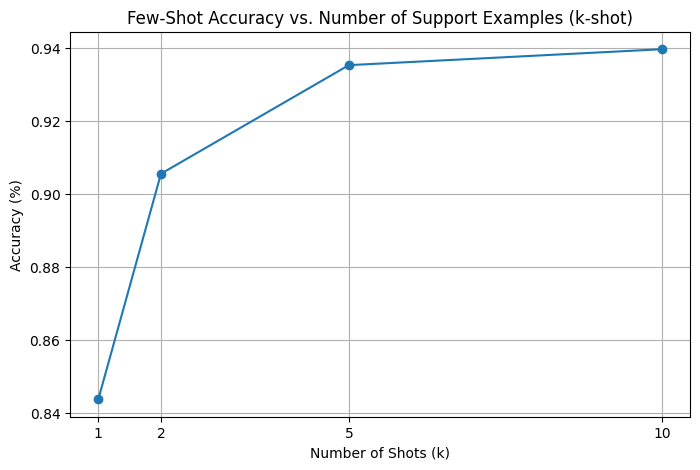


✓ Visualization of k-shot experimentation complete.


In [13]:
# Plot the results of the k-shot experiment
plt.figure(figsize=(8, 5))
plt.plot(list(k_shot_accuracies.keys()), list(k_shot_accuracies.values()), marker='o')
plt.title('Few-Shot Accuracy vs. Number of Support Examples (k-shot)')
plt.xlabel('Number of Shots (k)')
plt.ylabel('Accuracy (%)')
plt.xticks(list(k_shot_accuracies.keys())) # Ensure x-axis ticks match k_shot values
plt.grid(True)
plt.show()

print("\n✓ Visualization of k-shot experimentation complete.")